In [1]:
import os
import base64
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents import SearchClient
from azure.search.documents.indexes.models import (
    SimpleField,
    SearchFieldDataType,
    SearchableField,
    SearchField,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile,
    SearchIndex
)
from azure.search.documents.models import VectorizedQuery

from dotenv import load_dotenv

In [2]:
## Load environment variables from a .env file

load_dotenv()

# Load Azure OpenAI credentials and configuration
azure_openai_key = os.environ["AZURE_OPENAI_KEY"]
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_api_version = os.environ["AZURE_OPENAI_API_VERSION"]
azure_openai_embedding_deployment = os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"]
azure_openai_embedding_dimensions = int(os.environ["AZURE_OPENAI_EMBEDDING_DIMENSIONS"])
azure_openai_chat_endpoint = os.environ["AZURE_OPENAI_CHATGPT_ENDPOINT"]

# Initialize the Azure OpenAI client for embeddings
embeddings_client = AzureOpenAI(
    api_key=azure_openai_key,
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)

# Load Azure Search (Vector DB) credentials and configuration
vdb_endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
vdb_credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"])
vdb_index_name = 'test-kacamata-index'  # Name of the index for vector database

# Initialize clients for index and search operations in Azure Search
index_client = SearchIndexClient(endpoint=vdb_endpoint, credential=vdb_credential)
search_client = SearchClient(endpoint=vdb_endpoint, index_name=vdb_index_name, credential=vdb_credential)

Sample Data


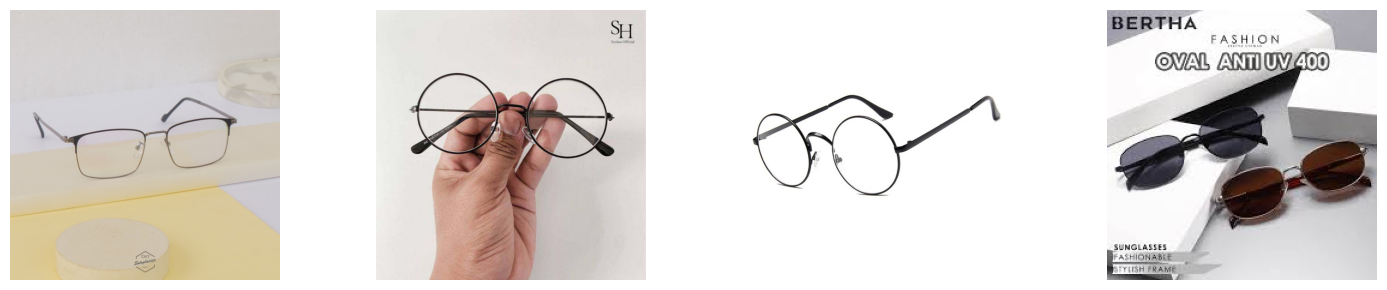

In [3]:
## Show sample data used for this example.

file_list = os.listdir('data/')

num_columns = 4
num_rows = 1

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))
axes = axes.flatten()

for i, image_file in enumerate(file_list):
    image_path = os.path.join('data', image_file)
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

print("Sample Data")
plt.tight_layout()
plt.show()

In [39]:
## Create a dataset from sample images

# Function to encode an image for processing by LLM
def encode_image(path):
    # Check if the file extension is one of the supported image formats
    if path.split('.')[-1].lower() in ['jpg', 'jpeg', 'png']:
        # Read the image file and encode it in base64
        with open(path, 'rb') as image_file:
            encoded_image = base64.b64encode(image_file.read()).decode('ascii')
        return encoded_image
    return None

# Function to extract data from an image using gpt-4o model
def extract_image(prompt, encoded_image, key, endpoint):
    headers = {"Content-Type": "application/json", "api-key": key}

    # Payload for the request
    payload = {
        "model": "gpt-4o",
        "temperature": 0,
        "messages": [
            {
                "role": "system",
                "content": [
                    {
                        "type": "text",
                        "text": "You are an AI assistant that extracts data from documents and returns them as structured JSON objects. Do not return as a code block."
                    }
                ]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
                ]
            }
        ]
    }

    # Send request to the endpoint
    response = requests.post(endpoint, headers=headers, json=payload)
    return response.json()

# Function to ensure the result is in the desired JSON format
def parse_result(result):
    # Extract the content from the response
    answer = result['choices'][0]['message']['content']

    # Attempt to convert the string to JSON
    try:
        data_json = json.loads(answer)
        return data_json
    except json.JSONDecodeError:
        try:
            # Extract the JSON-like string from the response
            start_index = answer.find('{')
            end_index = answer.rfind('}') + 1
            answer_clean = answer[start_index:end_index]
            data_json = json.loads(answer_clean)
            return data_json
        except json.JSONDecodeError:
            print('Error parsing JSON')
            return {"metadata": "error", "bentuk": "error", "deskripsi": "error"}

# Define the prompt for extracting information
prompt = """Ekstrak semua informasi tentang kacamata dari data yang diberikan.

1. Bentuk: Klasifikasikan bentuk lensa menjadi oval, bulat, atau persegi.
2. Metadata: informasi tentang kacamata yang bisa disimpan.
3. Deskripsi: Berikan deskripsi terperinci tentang kacamata dari data yang diberikan, termasuk bentuk kacamata.
3. Jika ada informasi yang tidak tersedia, isi dengan "unknown".
4. Kembalikan dalam struktur JSON berikut sebagai satu-satunya respon:
{
  "metadata": {
    "merek": "",
    "jenis_gagang": "",
    "bahan": "",
    "warna_kacamata": "",
    "warna_gagang": ""
  },
  "bentuk": "",
  "deskripsi": ""
}
"""

# Get the list of files in the folder
file_list = os.listdir('data/')

data_kacamata = []

# Process each image file in the directory
for image in file_list:
    encoded = encode_image('data/' + image)
    if encoded:
        response = extract_image(prompt, encoded, azure_openai_key, azure_openai_chat_endpoint)
        result = parse_result(response)
        result['id'] = image.split('.')[0]
        result['path'] = 'data/' + image
        data_kacamata.append(result)

In [40]:
df_kacamata = pd.DataFrame(data_kacamata)
df_kacamata

,metadata,bentuk,deskripsi,id,path
0,"{'merek': 'unknown', 'jenis_gagang': 'unknown'...",persegi,Kacamata dengan lensa berbentuk persegi dan bi...,2afa0a0a-04d8-4c6a-a213-a35f9d6cf0be,data/2afa0a0a-04d8-4c6a-a213-a35f9d6cf0be.jpg
1,"{'merek': 'unknown', 'jenis_gagang': 'unknown'...",bulat,Kacamata dengan lensa berbentuk bulat dan bing...,c92e4ef6dea1581085272b5ccbc812bf,data/c92e4ef6dea1581085272b5ccbc812bf.jpg
2,"{'merek': 'unknown', 'jenis_gagang': 'unknown'...",bulat,Kacamata ini memiliki lensa berbentuk bulat de...,cb062b150cad772225e9fd3b676d235b,data/cb062b150cad772225e9fd3b676d235b.jpeg
3,"{'merek': 'Bertha', 'jenis_gagang': 'unknown',...",oval,"Kacamata Bertha dengan lensa berbentuk oval, d...",fsa845248e-dawfgeg25-sa88,data/fsa845248e-dawfgeg25-sa88.jpg


In [42]:
## embedding 

# Function to generate embeddings for a given text
def generate_embeddings(text, model=azure_openai_embedding_deployment):
    response = embeddings_client.embeddings.create(input=[text], model=model)
    return response.data[0].embedding

# Apply the embedding generation function to the 'deskripsi' column
df_kacamata['deskripsi_vektor'] = df_kacamata["deskripsi"].apply(lambda x: generate_embeddings(x))

df_kacamata

,metadata,bentuk,deskripsi,id,path,deskripsi_vektor
0,"{'merek': 'unknown', 'jenis_gagang': 'unknown'...",persegi,Kacamata dengan lensa berbentuk persegi dan bi...,2afa0a0a-04d8-4c6a-a213-a35f9d6cf0be,data/2afa0a0a-04d8-4c6a-a213-a35f9d6cf0be.jpg,"[0.0013217977248132229, -0.02946941927075386, ..."
1,"{'merek': 'unknown', 'jenis_gagang': 'unknown'...",bulat,Kacamata dengan lensa berbentuk bulat dan bing...,c92e4ef6dea1581085272b5ccbc812bf,data/c92e4ef6dea1581085272b5ccbc812bf.jpg,"[-0.009677723981440067, -0.03456183895468712, ..."
2,"{'merek': 'unknown', 'jenis_gagang': 'unknown'...",bulat,Kacamata ini memiliki lensa berbentuk bulat de...,cb062b150cad772225e9fd3b676d235b,data/cb062b150cad772225e9fd3b676d235b.jpeg,"[-0.01337938942015171, -0.035595010966062546, ..."
3,"{'merek': 'Bertha', 'jenis_gagang': 'unknown',...",oval,"Kacamata Bertha dengan lensa berbentuk oval, d...",fsa845248e-dawfgeg25-sa88,data/fsa845248e-dawfgeg25-sa88.jpg,"[0.011005191132426262, -0.013492954894900322, ..."


In [46]:
## create index

# Define the schema for the index
fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True),  
    SimpleField(name="bentuk", type=SearchFieldDataType.String),  
    SearchableField(name="deskripsi", type=SearchFieldDataType.String),
    SearchField(
        name="deskripsi_vektor",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
        searchable=True,
        vector_search_dimensions=azure_openai_embedding_dimensions,
        vector_search_profile_name="myHnswProfile"
    ),  
    SimpleField(name="path", type=SearchFieldDataType.String),
]

# Configure the vector search with HNSW algorithm
vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(name="myHnsw")
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswProfile",
            algorithm_configuration_name="myHnsw"
        ) 
    ],
)

# Create the search index with the defined fields and vector search configuration
index = SearchIndex(
    name=vdb_index_name,
    fields=fields,
    vector_search=vector_search
)

# Create or update the index in Azure Search
result = index_client.create_or_update_index(index)
print(f'Vector database named "{result.name}" created')

Vector database named "test-kacamata-index" created


In [47]:
## Load data into a vector database

# Select relevant columns from the DataFrame and convert them to a list of dictionaries
data_load = df_kacamata[['id', 'bentuk', 'deskripsi', 'deskripsi_vektor', 'path']].to_dict(orient='records')

# Upload data to the index
search_client.upload_documents(data_load)

# Print the number of documents uploaded
print(f"Uploaded {len(data_load)} documents")

Uploaded 4 documents


In [48]:
# # delete index
# index_client.delete_index(vdb_index_name)

In [49]:
## Chatbot Preparation

# System prompt for the AI assistant
system_prompt = """Anda adalah Asisten AI yang menjawab pertanyaan tentang kacamata berdasarkan KATALOG yang ada. 
Jika pengguna meminta katalog spesifik, berikan jawaban sesuai detail yang diminta. 
Jika tidak ada informasi spesifik, tetapi ada yang mirip, Anda boleh merekomendasikan. 
Jika tidak ada KATALOG yang relevan, jawab dengan "Maaf, kami tidak punya katalog seperti yang Anda cari." 
Sertakan ID kacamata saat merekomendasikan.
Berikan respon yang terstruktur dan mudah dibaca, selalu pastikan jawaban Anda sesuai dengan pertanyaan."""

# Headers for the API request
headers = {"Content-Type": "application/json", "api-key": azure_openai_key}

# Function to perform vector search
def vector_search(query, top_k=3):
    knowledges = ''

    # Create a vectorized query using the generate_embeddings function
    vector_query = VectorizedQuery(vector=generate_embeddings(query), k_nearest_neighbors=top_k, fields="deskripsi_vektor")

    # Perform the search using the search client
    results = search_client.search(
        search_text=None,
        vector_queries=[vector_query],
        select=["id", "deskripsi", "path"]
    )

    # Compile the search results into a formatted string
    for result in results:
        knowledges += f"id_kacamata:{result['id']}\ndeskripsi_kacamata:{result['deskripsi']}\n"

    return knowledges

# Function to handle question answering
def rag_qa(question):
    # Perform vector search to get relevant knowledge
    knowledges = vector_search(question)

    # Create a prompt for the AI model
    prompt = f"""
    Question: {question}
    KATALOG: {knowledges}
    """

    # Payload for the API request
    payload = {
        "model": "gpt-4o",
        "temperature": 0,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
        ]
    }

    # Send the request to the Azure OpenAI endpoint and get the response
    response = requests.post(azure_openai_chat_endpoint, headers=headers, json=payload).json()
    return response

In [50]:
## Chatbot Simulation

question = "Adakah yang merek Bertha?"
print('Q:',question)
answer = rag_qa(question)['choices'][0]['message']['content']
print('A:',answer)

print()
question = "kacamata bentuk oval, tapi harus warna pink"
print('Q:',question)
answer = rag_qa(question)['choices'][0]['message']['content']
print('A:',answer)

print()
question = "adakah kacamata lensa bulat, kalau bisa warna hitam"
print('Q:',question)
answer = rag_qa(question)['choices'][0]['message']['content']
print('A:',answer)

print()
question = "rekomendasikan kacamata bentuk bulat"
print('Q:',question)
answer = rag_qa(question)['choices'][0]['message']['content']
print('A:',answer)

Q: Adakah yang merek Bertha?
A: Berikut adalah kacamata merek Bertha yang tersedia dalam katalog kami:

- **ID Kacamata:** fsa845248e-dawfgeg25-sa88
  - **Deskripsi:** Kacamata Bertha dengan lensa berbentuk oval, dilengkapi dengan perlindungan UV 400. Tersedia dalam warna lensa hitam dan coklat.

Silakan hubungi kami jika Anda memerlukan informasi lebih lanjut.

Q: kacamata bentuk oval, tapi harus warna pink
A: Maaf, kami tidak punya katalog seperti yang Anda cari.

Q: adakah kacamata lensa bulat, kalau bisa warna hitam
A: Berikut adalah kacamata dengan lensa bulat dan bingkai berwarna hitam yang tersedia dalam katalog kami:

1. **ID Kacamata: c92e4ef6dea1581085272b5ccbc812bf**
   - Deskripsi: Kacamata dengan lensa berbentuk bulat dan bingkai berwarna hitam. Gagang kacamata juga berwarna hitam.

2. **ID Kacamata: cb062b150cad772225e9fd3b676d235b**
   - Deskripsi: Kacamata ini memiliki lensa berbentuk bulat dengan bingkai dan gagang berwarna hitam. Desainnya sederhana dan klasik, cocok 